In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
import Categorization
import torch
import copy
from torch.nn.functional import one_hot
import imblearn
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH
from concurrent.futures import ProcessPoolExecutor
from PIL import Image
import os
import random


In [2]:
th = TH()

mimicDF = th.get_mimic()

mimicDF

PatientID  Mortality14Days  ALT  AST  Admit Ht  Albumin  \
0         178177                0  NaN  NaN       NaN      NaN   
1         178177                0  NaN  NaN       NaN      NaN   
2         178177                0  NaN  NaN       NaN      NaN   
3         178177                0  NaN  NaN       NaN      NaN   
4         178177                0  NaN  NaN       NaN      NaN   
...          ...              ...  ...  ...       ...      ...   
47083     159740                0  NaN  NaN       NaN      NaN   
47084     159740                0  NaN  NaN       NaN      NaN   
47085     159740                0  NaN  NaN       NaN      NaN   
47086     159740                0  NaN  NaN       NaN      NaN   
47087     159740                0  NaN  NaN       NaN      NaN   

       Arterial BP Mean  Arterial BP [Diastolic]  Arterial BP [Systolic]  \
0                   NaN                      NaN                     NaN   
1                   NaN                      NaN                     NaN   
2                   NaN                      NaN                     NaN   
3                   NaN                      NaN                     NaN   
4                   NaN                      NaN                     NaN   
...                 ...                      ...                     ...   
47083               NaN                      NaN                     NaN   
47084               NaN                      NaN                     NaN   
47085               NaN                      NaN                     NaN   
47086               NaN                      NaN                     NaN   
47087               NaN                      NaN                     NaN   

       Arterial PaCO2  ...  SVI  SVR  SVRI  SaO2  Sodium  SpO2  SvO2  \
0                 NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
1                 NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
2                 NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
3                 NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
4                 NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
...               ...  ...  ...  ...   ...   ...     ...   ...   ...   
47083             NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
47084             NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
47085             NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
47086             NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
47087             NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   

       Temperature C  Total Bili  WBC  
0                NaN         NaN  NaN  
1                NaN         NaN  NaN  
2                NaN         NaN  NaN  
3                NaN         NaN  NaN  
4                NaN         NaN  NaN  
...              ...         ...  ...  
47083            NaN         NaN  NaN  
47084            NaN         NaN  NaN  
47085            NaN         NaN  NaN  
47086            NaN         NaN  NaN  
47087            NaN         NaN  NaN  

[47088 rows x 44 columns]

In [3]:
mimicDF[mimicDF['Arterial pH'] > 8]

PatientID  Mortality14Days  ALT  AST  Admit Ht  Albumin  \
36229     198163                0  NaN  NaN       NaN      NaN   

       Arterial BP Mean  Arterial BP [Diastolic]  Arterial BP [Systolic]  \
36229              87.0                     76.0                   120.0   

       Arterial PaCO2  ...  SVI  SVR  SVRI  SaO2  Sodium   SpO2  SvO2  \
36229            29.0  ...  NaN  NaN   NaN   NaN     NaN  100.0   NaN   

       Temperature C  Total Bili  WBC  
36229      37.900002         NaN  NaN  

[1 rows x 44 columns]

In [4]:
# Too many columns to display all in one cell.

step = 10

for idx in range(0, len(mimicDF.columns), step):
    tempCols = mimicDF.columns[idx:idx+step]
    display(mimicDF[tempCols].describe())

PatientID  Mortality14Days          ALT           AST    Admit Ht  \
count   47088.000000     47088.000000   484.000000    481.000000  705.000000   
mean   151079.910805         0.039755   630.123967    954.301455   67.382553   
std     29378.613191         0.195386  1245.805613   2384.326867    5.448469   
min    100059.000000         0.000000     3.000000      3.000000   48.000000   
25%    126241.000000         0.000000    25.000000     49.000000   64.000000   
50%    151857.000000         0.000000    97.000000    137.000000   68.000000   
75%    176484.000000         0.000000   554.750000    797.000000   70.000000   
max    199998.000000         1.000000  8100.000000  23060.000000  160.000000   

          Albumin  Arterial BP Mean  Arterial BP [Diastolic]  \
count  245.000000      31415.000000             31503.000000   
mean     2.721633         77.058157                57.226709   
std      0.584693         14.324177                11.197415   
min      1.400000          0.000000                 0.000000   
25%      2.400000         68.000000                50.000000   
50%      2.700000         75.000000                56.000000   
75%      3.000000         84.000000                63.000000   
max      4.400000        287.000000               191.000000   

       Arterial BP [Systolic]  Arterial PaCO2  
count            31504.000000     8601.000000  
mean               117.544502       40.565399  
std                 21.311674        7.078312  
min                  0.000000       15.000000  
25%                103.000000       36.000000  
50%                115.000000       40.000000  
75%                129.000000       44.000000  
max                255.000000       91.000000

Arterial PaO2  Arterial pH          BUN           CVP         CaO2  \
count    8582.000000  9143.000000  1978.000000  27657.000000  3667.000000   
mean      152.720982     7.400322    24.094034     11.796478    13.867385   
std        92.767596     1.879658    14.906156      5.155437     1.898516   
min         7.470000     6.920000     3.000000      0.000000     0.706800   
25%        90.000000     7.340000    14.000000      8.000000    12.651100   
50%       118.000000     7.380000    20.000000     11.000000    13.784700   
75%       174.750000     7.420000    31.000000     15.000000    14.918100   
max       499.000000   187.000000   143.000000     50.000000    22.196800   

          Chloride   Creatinine  Daily Weight  Fibrinogen      Glucose  
count  1741.000000  1982.000000    956.000000  572.000000  7978.000000  
mean    107.547961     1.475732     91.145711  248.688986   125.757458  
std       4.878126     1.330165     22.804774  123.542862    40.834841  
min      87.000000     0.200000      0.000000   68.000000    26.000000  
25%     105.000000     0.800000     75.500000  166.750000   101.000000  
50%     108.000000     1.100000     88.650002  213.500000   119.000000  
75%     111.000000     1.500000    104.099998  301.250000   142.000000  
max     133.000000    12.500000    208.199997  925.000000   638.000000

Heart Rate   Hemoglobin          INR  Ionized Calcium           LDH  \
count  34081.000000  3487.000000  1909.000000      6518.000000    215.000000   
mean      86.659987    10.381594     1.459246         1.247281   1209.302326   
std       14.619726     1.536069     0.857355         3.527599   1870.129434   
min        0.000000     0.000000     0.600000         0.490000    152.000000   
25%       78.000000     9.400000     1.200000         1.090000    318.500000   
50%       86.000000    10.300000     1.300000         1.150000    439.000000   
75%       95.000000    11.200000     1.500000         1.200000   1037.000000   
max      223.000000    19.100000    27.000000       160.000000  12240.000000   

         Magnesium     NBP Mean  NBP [Diastolic]  NBP [Systolic]          PTT  
count  1881.000000  5404.000000      5451.000000     5473.000000  1937.000000  
mean      2.138437    73.803848        54.465603      114.147040    41.343211  
std       0.417471    13.540250        13.884506       21.738575    20.785616  
min       0.800000     0.000000         0.000000        0.000000    21.300000  
25%       1.900000    64.666702        45.000000      100.000000    30.400000  
50%       2.100000    72.333298        53.000000      112.000000    35.400000  
75%       2.300000    81.333298        63.000000      126.000000    43.600000  
max       4.500000   149.000000       125.000000      234.000000   150.000000

Platelets     Potassium  Resp Rate (Spont)  \
count  3222.000000   5717.000000        4043.000000   
mean    142.337678     15.009138           2.345041   
std      65.006060    810.131474           4.719276   
min      18.000000      2.300000           0.000000   
25%      97.000000      3.900000           0.000000   
50%     131.000000      4.200000           0.000000   
75%     174.000000      4.600000           3.000000   
max     689.000000  61259.000000          38.000000   

       Respiratory Rate (spontaneous)           SVI           SVR  \
count                             1.0  12981.000000  14768.000000   
mean                              5.0     33.217492    987.290546   
std                               NaN     10.474703    363.504762   
min                               5.0      0.000000      0.000000   
25%                               5.0     26.168200    737.500000   
50%                               5.0     31.460699    931.028503   
75%                               5.0     38.118801   1169.229980   
max                               5.0    179.212997   3784.620117   

               SVRI         SaO2       Sodium          SpO2  
count  14714.000000  4352.000000  2485.000000  32961.000000  
mean    1917.421073    96.799012   138.022942     97.267665  
std      608.801780     2.659592     5.435978      3.083466  
min        0.000000    42.000000     1.210000      0.000000  
25%     1494.877533    96.000000   136.000000     96.000000  
50%     1841.049988    97.000000   138.000000     98.000000  
75%     2244.340088    98.000000   140.000000    100.000000  
max     6000.000000   100.000000   164.000000    100.000000

SvO2  Temperature C  Total Bili          WBC
count   85.000000   26516.000000  331.000000  2118.000000
mean    64.988235      37.235334    2.529305    12.747691
std     10.518118       1.399548    3.004787     5.523420
min     43.000000       0.000000    0.000000     1.900000
25%     58.000000      36.900002    0.600000     9.000000
50%     65.000000      37.299999    1.400000    11.900000
75%     71.000000      37.700001    3.300000    15.500000
max    100.000000      46.500000   16.400000    48.300000

In [5]:
# Fixing 'arterial pH', 'ionized calcium' since they contain erroneous values.

mimicDF['Arterial pH'][mimicDF['Arterial pH'] > 8] = mimicDF['Arterial pH'].mean()
mimicDF['Ionized Calcium'][mimicDF['Ionized Calcium'] > 8] = mimicDF['Ionized Calcium'].mean()

C:\Users\benma\AppData\Local\Temp/ipykernel_8056/153206369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mimicDF['Arterial pH'][mimicDF['Arterial pH'] > 8] = mimicDF['Arterial pH'].mean()
C:\Users\benma\AppData\Local\Temp/ipykernel_8056/153206369.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mimicDF['Ionized Calcium'][mimicDF['Ionized Calcium'] > 8] = mimicDF['Ionized Calcium'].mean()


In [6]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [7]:
patients = th.get_patients(mimicDF)

print(len(patients))

100%|██████████| 1126/1126 [00:01<00:00, 747.93it/s]

1126


In [8]:
minorityClass = [patient for patient in patients if patient.label == 1]
majorityClass = [patient for patient in patients if patient.label == 0]

print(len(minorityClass), len(majorityClass))

49 1077


In [9]:
totalNullColumns = 0

for patient in patients:
    totalNullColumns += patient.data.isnull().all().sum()

totalColumns = len(patient.data.columns) * len(patients)

print(totalColumns, totalNullColumns)

print(f"{np.round(totalNullColumns / totalColumns * 100, 2)}% of columns are null")

47292 15553
32.89% of columns are null


Counting how many columns have no data in 

[1/4] Counting null values...


100%|██████████| 1126/1126 [00:00<00:00, 1332.67it/s]


[2/3] Copying dataset...
[3/4] Dropping null columns...


100%|██████████| 39/39 [00:03<00:00, 11.98it/s]


[4/4] Graphing...


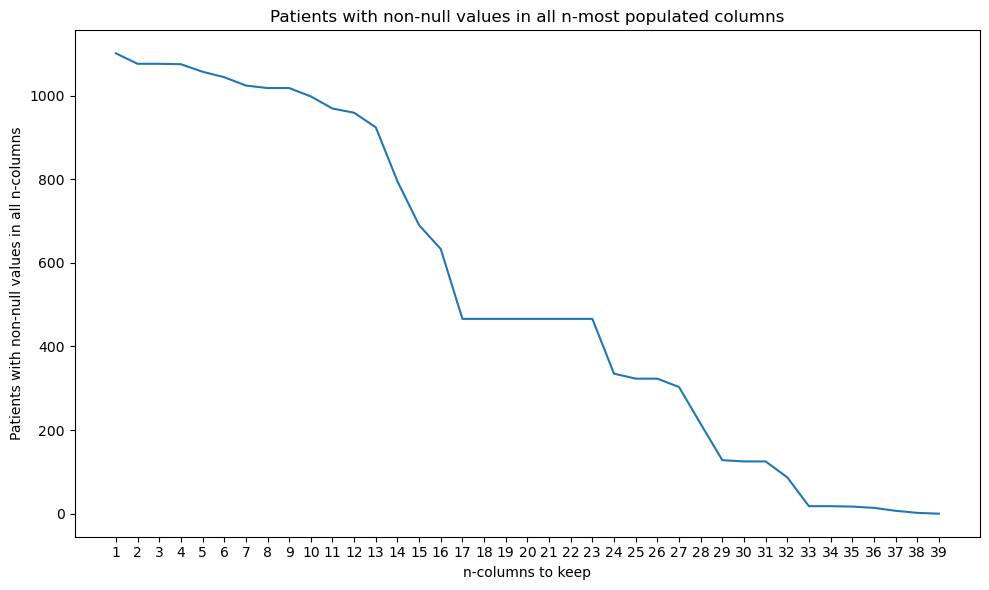

In [10]:
patientsKept, columnsExplored = th.count_null(patients)

#### Sharp drop off after 12 columns so will keep around 1000 patients with at least some data in the top 12 columns

In [32]:
# clusteringPatients = th.get_top_columns(patients, 12)

clusteringPatients = patients

for patient in clusteringPatients:
    patient.topColumns = patient.data

print(len(clusteringPatients))

clusteringPatients[0].data

1126


ALT  AST  Admit Ht  Albumin  Arterial BP Mean  Arterial BP [Diastolic]  \
0   NaN  NaN       NaN      NaN               NaN                      NaN   
1   NaN  NaN       NaN      NaN               NaN                      NaN   
2   NaN  NaN       NaN      NaN               NaN                      NaN   
3   NaN  NaN       NaN      NaN               NaN                      NaN   
4   NaN  NaN       NaN      NaN               NaN                      NaN   
5   NaN  NaN       NaN      NaN               NaN                      NaN   
6   NaN  NaN       NaN      NaN               NaN                      NaN   
7   NaN  NaN       NaN      NaN               NaN                      NaN   
8   NaN  NaN       NaN      NaN               NaN                      NaN   
9   NaN  NaN       NaN      NaN               NaN                      NaN   
10  NaN  NaN       NaN      NaN               NaN                      NaN   
11  NaN  NaN       NaN      NaN               NaN                      NaN   
12  NaN  NaN       NaN      NaN               NaN                      NaN   
13  NaN  NaN       NaN      NaN               NaN                      NaN   
14  NaN  NaN       NaN      NaN               NaN                      NaN   
15  NaN  NaN       NaN      NaN               NaN                      NaN   
16  NaN  NaN       NaN      NaN               NaN                      NaN   
17  NaN  NaN       NaN      NaN               NaN                      NaN   
18  NaN  NaN      66.0      NaN               NaN                      NaN   
19  NaN  NaN       NaN      NaN               NaN                      NaN   
20  NaN  NaN       NaN      NaN               NaN                      NaN   
21  NaN  NaN       NaN      NaN              61.0                     43.0   
22  NaN  NaN       NaN      NaN              72.0                     47.0   
23  NaN  NaN       NaN      NaN              69.0                     51.0   
24  NaN  NaN       NaN      NaN              67.0                     51.0   
25  NaN  NaN       NaN      NaN              77.0                     61.0   
26  NaN  NaN       NaN      NaN             102.0                     54.0   
27  NaN  NaN       NaN      NaN              73.0                     53.0   
28  NaN  NaN       NaN      NaN              77.0                     54.0   
29  NaN  NaN       NaN      NaN              72.0                     53.0   
30  NaN  NaN       NaN      NaN              66.0                     47.0   
31  NaN  NaN       NaN      NaN              72.0                     50.0   
32  NaN  NaN       NaN      NaN              86.0                     61.0   
33  NaN  NaN       NaN      NaN              75.0                     49.0   
34  NaN  NaN       NaN      NaN              83.0                     58.0   
35  NaN  NaN       NaN      NaN              60.0                     44.0   
36  NaN  NaN       NaN      NaN              62.0                     46.0   
37  NaN  NaN       NaN      NaN              71.0                     52.0   
38  NaN  NaN       NaN      NaN              64.0                     45.0   
39  NaN  NaN       NaN      NaN              60.0                     44.0   
40  NaN  NaN       NaN      NaN              64.0                     47.0   
41  NaN  NaN       NaN      NaN              62.0                     44.0   
42  NaN  NaN       NaN      NaN              80.0                     61.0   
43  NaN  NaN       NaN      NaN              81.0                     62.0   
44  NaN  NaN       NaN      NaN              84.0                     64.0   
45  NaN  NaN       NaN      NaN              81.0                     60.0   
46  NaN  NaN       NaN      NaN              92.0                     66.0   
47  NaN  NaN       NaN      NaN              75.0                     52.0   

    Arterial BP [Systolic]  Arterial PaCO2  Arterial PaO2  Arterial pH  ...  \
0                      NaN             NaN            NaN          NaN  ...   
1                      

In [29]:
allDataTemp = pd.concat([patient.data for patient in clusteringPatients])
allDataTemp = allDataTemp.describe().T['mean'].T
allDataTemp['ALT']

630.1239669421487

In [41]:
clusteringPatients[0].topColumns.count()

ALT                                0
AST                                0
Admit Ht                           1
Albumin                            0
Arterial BP Mean                  27
Arterial BP [Diastolic]           27
Arterial BP [Systolic]            27
Arterial PaCO2                    14
Arterial PaO2                     14
Arterial pH                       15
BUN                                2
CVP                               19
CaO2                               1
Chloride                           2
Creatinine                         2
Daily Weight                       1
Fibrinogen                         1
Glucose                           23
Heart Rate                        27
Hemoglobin                         2
INR                                2
Ionized Calcium                   11
LDH                                0
Magnesium                          2
NBP Mean                           0
NBP [Diastolic]                    0
NBP [Systolic]                     0
P

In [59]:
# columnsToInterpolate = ['Glucose']

noInterpolation = 0
failureExample = (0,0)



for idx, patient in tqdm(enumerate(clusteringPatients)):

    # print(patient.topColumns)

    patient.interpolatedData = copy.copy(patient.topColumns)

    patientNonNullCount = patient.topColumns.count()

    for column in patient.topColumns.columns:

        # print(patient.topColumns[column])

        if patient.topColumns[column].isnull().all():
            print("replacing ", column)
            print(allDataTemp[column])
            patient.interpolatedData[column] = allDataTemp[column]
            continue

        try:
            # print(patient.data.isnull().all())
            patient.interpolatedData[column] = patient.topColumns[column].interpolate(method='polynomial', order=2, limit_direction='both', limit_area='inside')

    
        except ValueError:

            try:

                if patientNonNullCount[column] == 1:
                    patient.interpolatedData[column] = patient.topColumns[column].interpolate(method='linear', limit_direction='both', limit=3)
                elif patientNonNullCount[column] == 0:
                    print("no data in ", column)
                    break
                else: 
                    patient.interpolatedData[column] = patient.topColumns[column].interpolate(method='linear', limit_direction='both', limit_area='inside')
            
            except ValueError:

                patient.interpolatedData[column] = patient.topColumns[column].fillna(allDataTemp[column])
                noInterpolation += 1
                failureExample = (idx, column)


        # if patient.interpolatedData[column].shape[0] < 48:
        #     print("Got here")
        #     patient.interpolatedData[column] = np.pad(patient.interpolatedData[column], (0, 48 - patient.interpolatedData[column]), 'constant', constant_values=np.nan)

    if patient.interpolatedData.shape[0] != 48:
        # print("Not 28")
        fixedData = []
        for col in patient.interpolatedData:
            fixedData.append(np.pad(patient.interpolatedData[col], (0, 48 - patient.interpolatedData[col].shape[0]), 'constant', constant_values=np.nan))

        # print(fixedData)

        tempDF = pd.DataFrame(data = fixedData).T
        tempDF.columns = patient.interpolatedData.columns
        patient.interpolatedData = tempDF

    break

# Is this true?
print(f"{noInterpolation}/{len(clusteringPatients)} patients failed to interpolate all columns")
print(f"{failureExample}")

0it [00:00, ?it/s]

0/1126 patients failed to interpolate all columns
(0, 0)


In [124]:
for patient in clusteringPatients:
    for col in patient.interpolatedData:
        if patient.interpolatedData[col].isnull().all():
            print("replacing ", col)
            patient.interpolatedData[col] = allDataTemp[col]

In [156]:
# withIDs = []

# tempPatientse = copy.deepcopy()

# for patient in clusteringPatients:
#     patient.interpolatedData['PatientID'] = patient.label
#     patient.interpolatedData['Mortality14Days'] = patient.label
#     withIDs.append(patient)


# cleanedTimeSeriesDF = pd.concat([patient.interpolatedData for patient in withIDs])

# cleanedTimeSeriesDF = cleanedTimeSeriesDF.set_index('PatientID')

# cleanedTimeSeriesDF['Mortality14Days'] = mortality

# cleanedTimeSeriesDF.to_csv("cleanedTemporalData.csv")

In [157]:
# def plotPatient(patient=1, feature='Platelets'):

#     patient = clusteringPatients[patient]

#     # fig = plt.figure(figsize = (30, 1.5))

#     # plt.subplot(1, len(clusteringPatients[i].interpolatedData.columns), idx+1)
#     # plt.plot(patient.interpolatedData.index, patient.interpolatedData[col])
#     # plt.scatter(patient.interpolatedData.index, patient.interpolatedData[col])
#     # plt.scatter(patient.topColumns.index, patient.topColumns[col])
#     # plt.title(f"Patient: {patient}")

#     fig = plt.figure()
    
#     fig.show()

#     ax = fig.add_subplot(1,1,1)

#     ax.plot(patient.interpolatedData[feature])

#     ax.scatter(patient.interpolatedData[feature].index, patient.interpolatedData[feature])

#     ax.scatter(patient.topColumns[feature].index, patient.topColumns[feature], c="Orange")


#     output = ax.get_figure()

#     plt.close(output)

#     return output


In [158]:
# plotPatient(7, 'Platelets')

In [159]:
# import panel as pn

# pn.extension()

# pn.interact(plotPatient, patient=(1, len(clusteringPatients)), feature = list(clusteringPatients[0].interpolatedData.columns)).show()

C:\Users\benma\AppData\Local\Temp/ipykernel_8056/2467793513.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, len(patient.topColumns.columns)/2, idx+1)


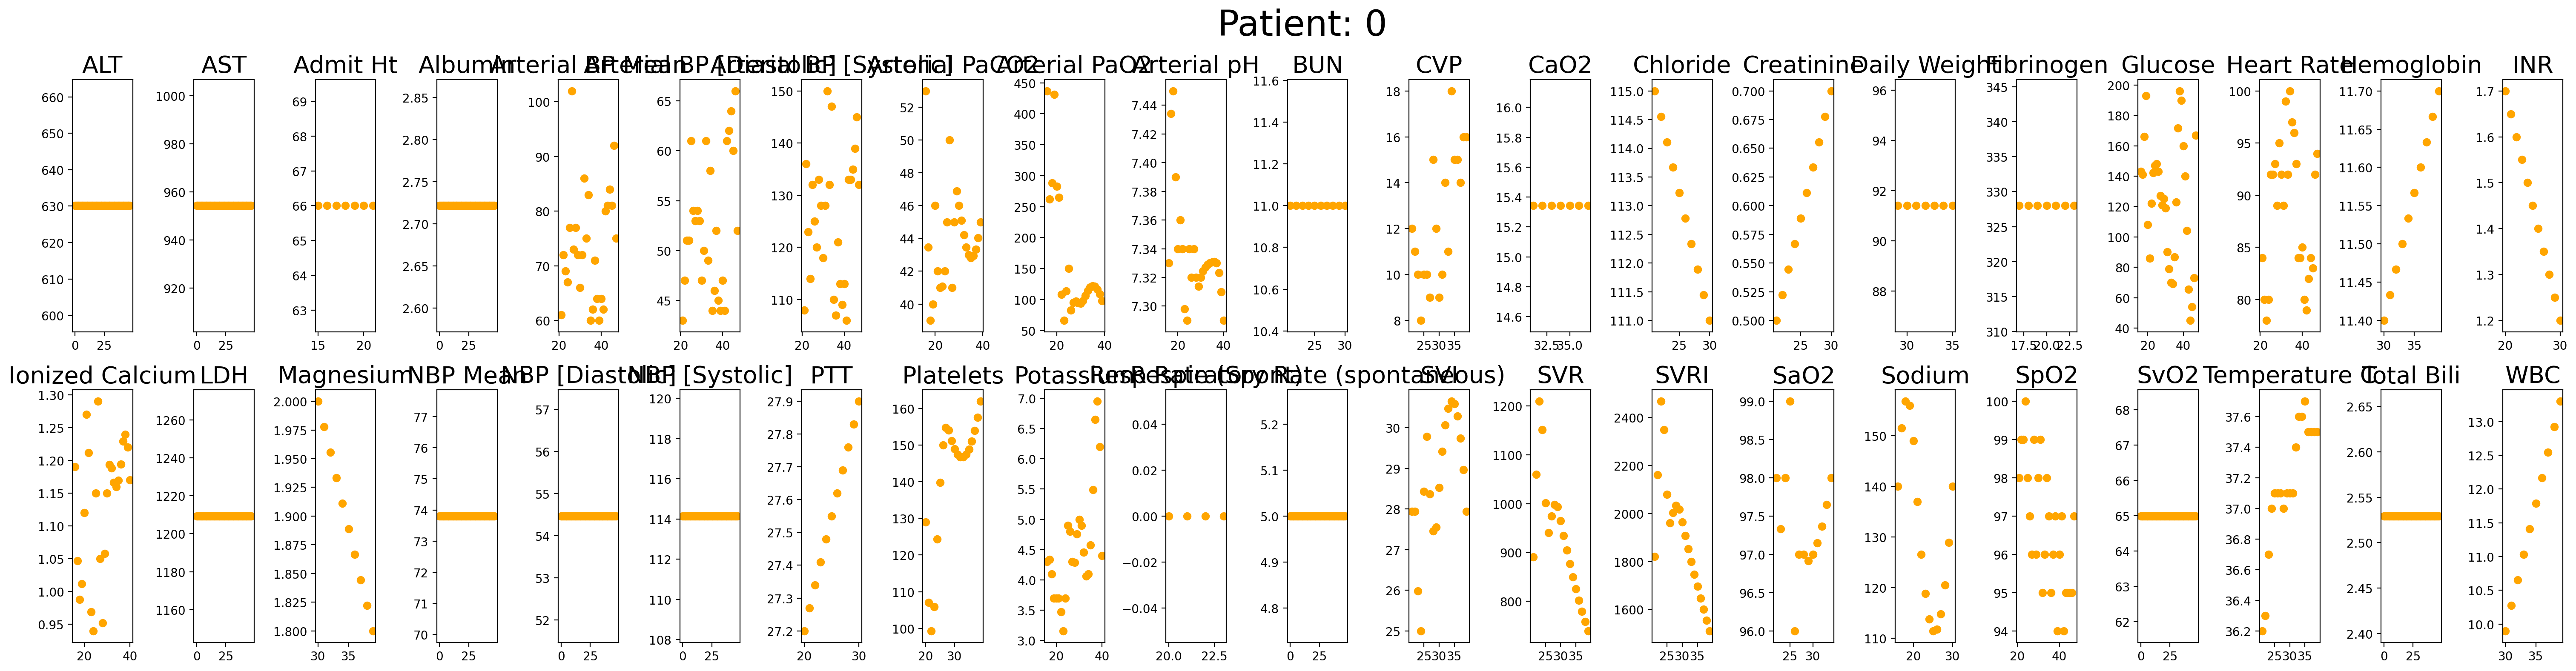

In [62]:
patient = clusteringPatients[0]

fig = plt.figure(figsize = (30, 8), dpi=200)


fig.suptitle(f"Patient: {patient.label}", fontsize=30)

for idx, col in enumerate(patient.topColumns.columns):
    plt.subplot(2, len(patient.topColumns.columns)/2, idx+1)

    plt.scatter(patient.topColumns.index, patient.topColumns[col], c='Orange')
    plt.title(f"{col}", fontsize=20)

plt.tight_layout()
plt.show()

In [63]:
patient.interpolatedData

ALT         AST  Admit Ht   Albumin  Arterial BP Mean  \
0   630.123967  954.301455       NaN  2.721633               NaN   
1   630.123967  954.301455       NaN  2.721633               NaN   
2   630.123967  954.301455       NaN  2.721633               NaN   
3   630.123967  954.301455       NaN  2.721633               NaN   
4   630.123967  954.301455       NaN  2.721633               NaN   
5   630.123967  954.301455       NaN  2.721633               NaN   
6   630.123967  954.301455       NaN  2.721633               NaN   
7   630.123967  954.301455       NaN  2.721633               NaN   
8   630.123967  954.301455       NaN  2.721633               NaN   
9   630.123967  954.301455       NaN  2.721633               NaN   
10  630.123967  954.301455       NaN  2.721633               NaN   
11  630.123967  954.301455       NaN  2.721633               NaN   
12  630.123967  954.301455       NaN  2.721633               NaN   
13  630.123967  954.301455       NaN  2.721633               NaN   
14  630.123967  954.301455       NaN  2.721633               NaN   
15  630.123967  954.301455      66.0  2.721633               NaN   
16  630.123967  954.301455      66.0  2.721633               NaN   
17  630.123967  954.301455      66.0  2.721633               NaN   
18  630.123967  954.301455      66.0  2.721633               NaN   
19  630.123967  954.301455      66.0  2.721633               NaN   
20  630.123967  954.301455      66.0  2.721633               NaN   
21  630.123967  954.301455      66.0  2.721633              61.0   
22  630.123967  954.301455       NaN  2.721633              72.0   
23  630.123967  954.301455       NaN  2.721633              69.0   
24  630.123967  954.301455       NaN  2.721633              67.0   
25  630.123967  954.301455       NaN  2.721633              77.0   
26  630.123967  954.301455       NaN  2.721633             102.0   
27  630.123967  954.301455       NaN  2.721633              73.0   
28  630.123967  954.301455       NaN  2.721633              77.0   
29  630.123967  954.301455       NaN  2.721633              72.0   
30  630.123967  954.301455       NaN  2.721633              66.0   
31  630.123967  954.301455       NaN  2.721633              72.0   
32  630.123967  954.301455       NaN  2.721633              86.0   
33  630.123967  954.301455       NaN  2.721633              75.0   
34  630.123967  954.301455       NaN  2.721633              83.0   
35  630.123967  954.301455       NaN  2.721633              60.0   
36  630.123967  954.301455       NaN  2.721633              62.0   
37  630.123967  954.301455       NaN  2.721633              71.0   
38  630.123967  954.301455       NaN  2.721633              64.0   
39  630.123967  954.301455       NaN  2.721633              60.0   
40  630.123967  954.301455       NaN  2.721633              64.0   
41  630.123967  954.301455       NaN  2.721633              62.0   
42  630.123967  954.301455       NaN  2.721633              80.0   
43  630.123967  954.301455       NaN  2.721633              81.0   
44  630.123967  954.301455       NaN  2.721633              84.0   
45  630.123967  954.301455       NaN  2.721633              81.0   
46  630.123967  954.301455       NaN  2.721633              92.0   
47  630.123967  954.301455       NaN  2.721633              75.0   

    Arterial BP [Diastolic]  Arterial BP [Systolic]  Arterial PaCO2  \
0                       NaN                     NaN             NaN   
1                       NaN                     NaN             NaN   
2                       NaN                     NaN             NaN   
3                       NaN                     NaN             NaN   
4                       NaN                     NaN             NaN   
5                       NaN                     NaN             NaN   
6                       NaN                     NaN             NaN   
7                       NaN                     NaN             NaN   
8                       NaN            

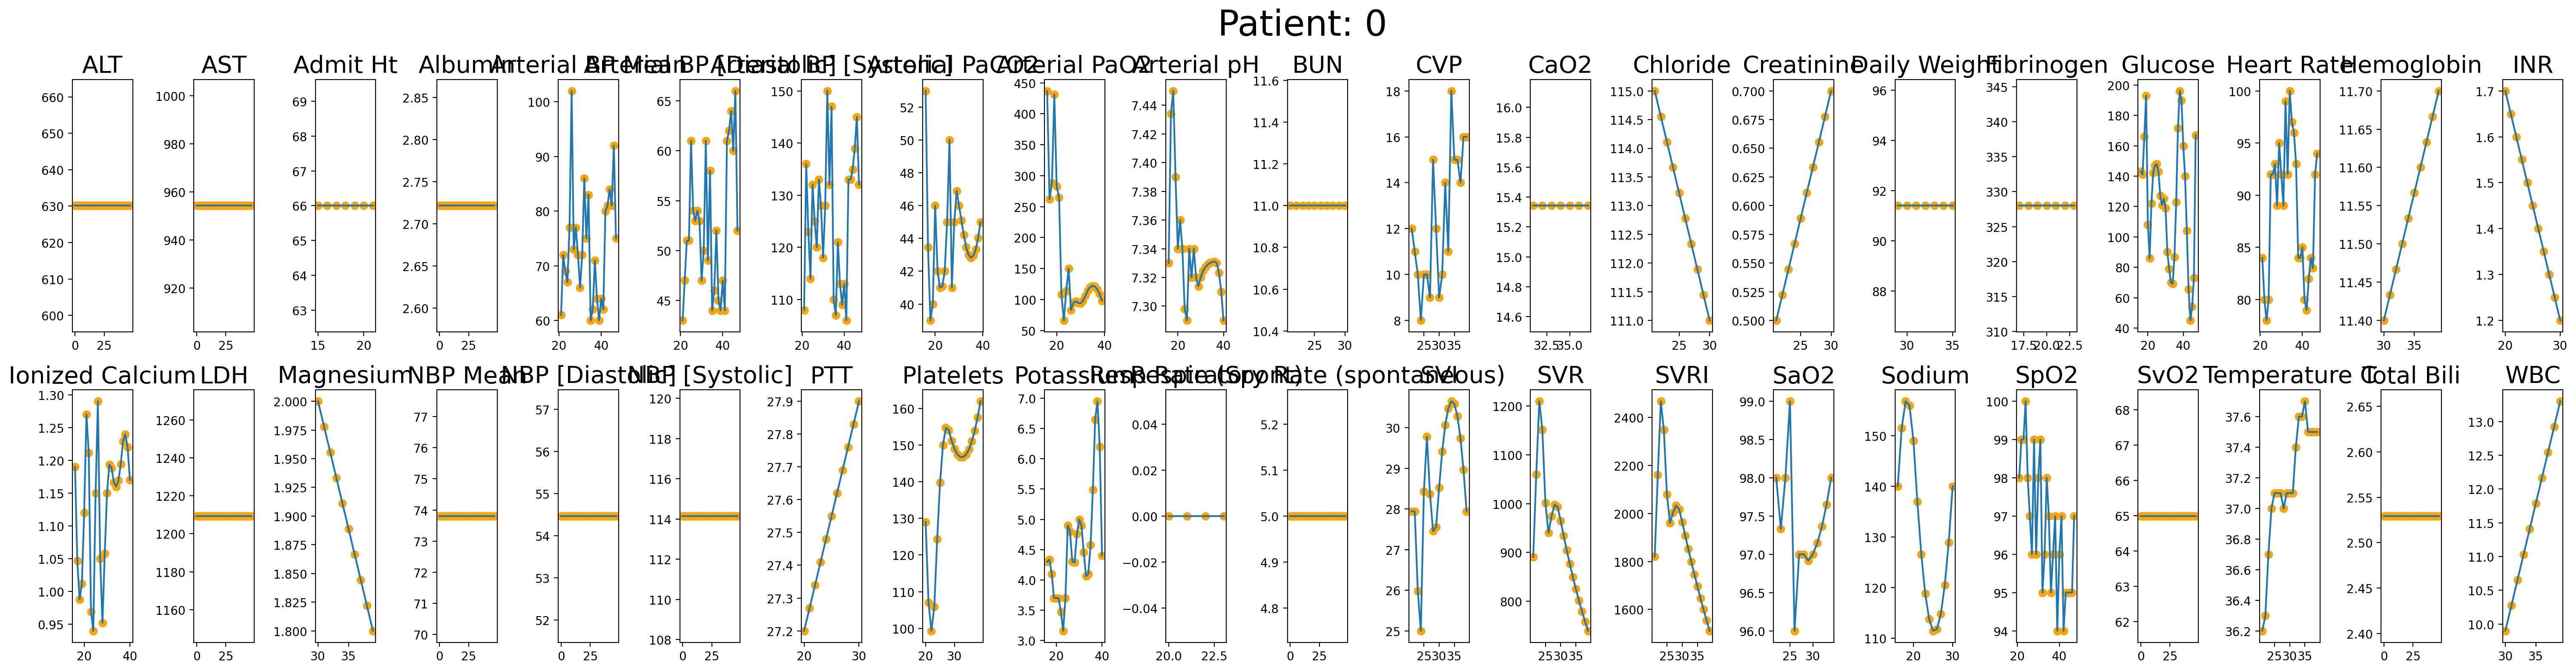

In [64]:
# TODO make these graphs bigger...


for patient in clusteringPatients[:1]:

    # display(clusteringPatients[i].interpolatedData.head())

    fig = plt.figure(figsize = (30, 8),dpi=200)


    fig.suptitle(f"Patient: {patient.label}", fontsize=30)

    for idx, col in enumerate(patient.interpolatedData.columns):
        plt.subplot(2, len(patient.interpolatedData.columns)//2, idx+1)

        plt.plot(patient.interpolatedData.index, patient.interpolatedData[col])
        plt.scatter(patient.interpolatedData.index, patient.interpolatedData[col])
        plt.scatter(patient.topColumns.index, patient.topColumns[col], c="Orange")
        plt.title(f"{col}", fontsize=20)

    plt.tight_layout()
    plt.show()

In [125]:

def formatForTimeSeries(column, sampleSize=None):

    if sampleSize is None:
        sampleList = clusteringPatients
    else:
        minorityClass = [patient for patient in clusteringPatients if patient.label == 1]
        majorityClass = [patient for patient in clusteringPatients if patient.label == 0]
        
        minorityList = random.choices(minorityClass, k=sampleSize//2)
        majorityList = random.choices(majorityClass, k=sampleSize//2)

        sampleList = minorityList + majorityList

        print(minorityList)

        # sampleList = random.shuffle(sampleList)

        

    print("Creating stacked DF...")
    stackedDF = pd.DataFrame([patient.interpolatedData[column].values for patient in sampleList])


    stackedNumpy = stackedDF.to_numpy()

    cleanedNumpy = []

    print("Cleaning")
    for row in stackedNumpy:
        cRow = row[~np.isnan(row)]
        if len(cRow) > 0:
            cleanedNumpy.append(cRow)

            
    dataFormatted = to_time_series_dataset([*cleanedNumpy])

    return dataFormatted



def timeSeriesCluster(clusters, dataFormatted):

    # print(f"Clustering {column}")

    # dataFormatted = formatForTimeSeries(column)

    # print(dataFormatted)


    # Change hyper-parameters for better results?

    print("Clustering")

    model = TimeSeriesKMeans(n_clusters=clusters, tol=1e-1, metric="dtw", max_iter=1, random_state=0, n_jobs=4)
    model.fit(dataFormatted)


    return model


In [126]:
def find_cached(df=None, hash=None):

    if hash is None:

        print("Hashing...")
        hash = hashlib.sha256(bytes(str(df), 'utf-8')).hexdigest()

    display(hash)


    try:
        cachedDF = pd.read_csv("./processingCache/" + hash + ".csv").set_index("PatientID")

        print("Using cached df")

        return cachedDF, hash

    except:

        print("No cached df found")

        return False, hash
    

In [131]:
myHash = "Chosen_clusters"


clusteredDF, myHash = find_cached(clusteringPatients, hash=myHash)

# clusters = 5


clusterNums = {"Platelets": 2, "Arterial BP [Diastolic]": 2, "Arterial BP [Systolic]": 2, "Arterial BP Mean": 2, "CVP": 2, "Arterial pH": 2, "Hemoglobin": 2, "Arterial PaCO2": 2, "Arterial PaO2": 2, "SVR": 2, "Ionized Calcium": 2, "SVRI": 2}

# Caching disabled
if False is False:

    clusteredDF = pd.DataFrame()

    for column in tqdm(clusteringPatients[0].interpolatedData.columns):
        dataFormatted = formatForTimeSeries(column)
        model = timeSeriesCluster(2, dataFormatted)

        print("Finished fitting. Predicting... ")


        print(column)
        dataFormattedAll = formatForTimeSeries(column)
        y_pred = model.predict(dataFormattedAll)
        clusteredDF[column] = y_pred

    ids = [patient.label for patient in clusteringPatients]

    clusteredDF["PatientID"] = ids

    clusteredDF = clusteredDF.set_index("PatientID")


    clusteredDF.to_csv("./processingCache/" + myHash + ".csv")

# else:
#     dataFormatted = formatForTimeSeries(column)

'Chosen_clusters'

Using cached df


  0%|          | 0/42 [00:00<?, ?it/s]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
ALT
Creating stacked DF...
Cleaning


  2%|▏         | 1/42 [00:05<03:59,  5.85s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
AST
Creating stacked DF...
Cleaning


  5%|▍         | 2/42 [00:11<03:40,  5.51s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Admit Ht
Creating stacked DF...
Cleaning


  7%|▋         | 3/42 [00:17<03:56,  6.07s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Albumin
Creating stacked DF...
Cleaning


 10%|▉         | 4/42 [00:22<03:28,  5.48s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Arterial BP Mean
Creating stacked DF...
Cleaning


 12%|█▏        | 5/42 [00:36<05:22,  8.72s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Arterial BP [Diastolic]
Creating stacked DF...
Cleaning


 14%|█▍        | 6/42 [00:53<06:46, 11.30s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Arterial BP [Systolic]
Creating stacked DF...
Cleaning


 17%|█▋        | 7/42 [01:07<07:10, 12.31s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Arterial PaCO2
Creating stacked DF...
Cleaning


 19%|█▉        | 8/42 [01:26<08:06, 14.30s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Arterial PaO2
Creating stacked DF...
Cleaning


 21%|██▏       | 9/42 [01:45<08:40, 15.77s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Arterial pH
Creating stacked DF...
Cleaning


 24%|██▍       | 10/42 [01:56<07:42, 14.45s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
BUN
Creating stacked DF...
Cleaning


 26%|██▌       | 11/42 [02:05<06:32, 12.66s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
CVP
Creating stacked DF...
Cleaning


 29%|██▊       | 12/42 [02:18<06:21, 12.73s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
CaO2
Creating stacked DF...
Cleaning


 31%|███       | 13/42 [02:26<05:34, 11.53s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Chloride
Creating stacked DF...
Cleaning


 33%|███▎      | 14/42 [02:35<04:55, 10.54s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Creatinine
Creating stacked DF...
Cleaning


 36%|███▌      | 15/42 [02:43<04:25,  9.84s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Daily Weight
Creating stacked DF...
Cleaning


 38%|███▊      | 16/42 [02:53<04:21, 10.06s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Fibrinogen
Creating stacked DF...
Cleaning


 40%|████      | 17/42 [03:03<04:04,  9.80s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Glucose
Creating stacked DF...
Cleaning


 43%|████▎     | 18/42 [03:13<03:57,  9.88s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Heart Rate
Creating stacked DF...
Cleaning


 45%|████▌     | 19/42 [03:26<04:09, 10.86s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Hemoglobin
Creating stacked DF...
Cleaning


 48%|████▊     | 20/42 [03:40<04:19, 11.79s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
INR
Creating stacked DF...
Cleaning


 50%|█████     | 21/42 [03:47<03:39, 10.43s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Ionized Calcium
Creating stacked DF...
Cleaning


 52%|█████▏    | 22/42 [03:59<03:36, 10.83s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
LDH
Creating stacked DF...
Cleaning


 55%|█████▍    | 23/42 [04:03<02:50,  8.97s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Magnesium
Creating stacked DF...
Cleaning


 57%|█████▋    | 24/42 [04:12<02:38,  8.80s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
NBP Mean
Creating stacked DF...
Cleaning


 60%|█████▉    | 25/42 [04:23<02:40,  9.44s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
NBP [Diastolic]
Creating stacked DF...
Cleaning


 62%|██████▏   | 26/42 [04:32<02:29,  9.33s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
NBP [Systolic]
Creating stacked DF...
Cleaning


 64%|██████▍   | 27/42 [04:42<02:22,  9.47s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
PTT
Creating stacked DF...
Cleaning


 67%|██████▋   | 28/42 [04:52<02:14,  9.63s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Platelets
Creating stacked DF...
Cleaning


 69%|██████▉   | 29/42 [05:05<02:18, 10.65s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Potassium
Creating stacked DF...
Cleaning


 71%|███████▏  | 30/42 [05:12<01:54,  9.57s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Resp Rate (Spont)
Creating stacked DF...
Cleaning


 74%|███████▍  | 31/42 [05:22<01:48,  9.89s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
Respiratory Rate (spontaneous)
Creating stacked DF...
Cleaning


 76%|███████▌  | 32/42 [05:38<01:55, 11.58s/it]

Creating stacked DF...
Cleaning
Clustering
Finished fitting. Predicting... 
SVI
Creating stacked DF...
Cleaning


 79%|███████▊  | 33/42 [05:50<01:45, 11.75s/it]

Creating stacked DF...
Cleaning
Clustering


In [ ]:
# colScores = {}

# for col in tqdm(clusteringPatients[0].interpolatedData.columns):
    
#     results = []

#     dataFormatted = formatForTimeSeries(col)
    
#     for c in range(2,11):
        
#         y_pred, model = timeSeriesCluster(c, dataFormatted)

#         score = silhouetteScoreCalc(dataFormatted, y_pred)

#         print(f"Score: {score}")

#         results.append([c, score, y_pred])

#     colScores[col] = results


In [ ]:
# print(list(range(2,12)))

In [ ]:
# [print(x) for x in list(colScores.keys())]

In [ ]:
# fig = plt.figure(figsize = (15, 12), dpi=200)

# for idx, col in enumerate(colScores):
#     scores = [x[1] for x in colScores[col]]
#     plt.subplot(4, len(colScores)//4, idx+1)
#     plt.title(col)
#     plt.ylabel("Silhouette Score")
#     plt.xlabel("Num clusters")
#     plt.plot(list(range(2,2+len(scores))), scores)
    
# fig.suptitle(f"Silhouette scores for clusters 2 to {1+len(scores)}", fontsize=30)
# plt.tight_layout()
# plt.show()

In [ ]:
# print(colScores)

In [ ]:
clusteredDF.describe()

Platelets  Arterial BP [Diastolic]  Arterial BP [Systolic]  \
count  959.000000               959.000000              959.000000   
mean     0.314911                 0.877998                0.353493   
std      0.464723                 0.327459                0.478304   
min      0.000000                 0.000000                0.000000   
25%      0.000000                 1.000000                0.000000   
50%      0.000000                 1.000000                0.000000   
75%      1.000000                 1.000000                1.000000   
max      1.000000                 1.000000                1.000000   

       Arterial BP Mean         CVP  Arterial pH  Hemoglobin  Arterial PaCO2  \
count        959.000000  959.000000   959.000000  959.000000      959.000000   
mean           0.345151    0.281543     0.345151    0.605839        0.535975   
std            0.475666    0.449986     0.475666    0.488925        0.498964   
min            0.000000    0.000000     0.000000    0.000000        0.000000   
25%            0.000000    0.000000     0.000000    0.000000        0.000000   
50%            0.000000    0.000000     0.000000    1.000000        1.000000   
75%            1.000000    1.000000     1.000000    1.000000        1.000000   
max            1.000000    1.000000     1.000000    1.000000        1.000000   

       Arterial PaO2         SVR  Ionized Calcium        SVRI  
count     959.000000  959.000000       959.000000  959.000000  
mean        0.608968    0.466111         0.184567    0.476538  
std         0.488236    0.499110         0.388149    0.499710  
min         0.000000    0.000000         0.000000    0.000000  
25%         0.000000    0.000000         0.000000    0.000000  
50%         1.000000    0.000000         0.000000    0.000000  
75%         1.000000    1.000000         0.000000    1.000000  
max         1.000000    1.000000         1.000000    1.000000

In [ ]:
def silhouetteScoreCalc(data, y_pred):

    test_size = 0.1
    sample_idx = np.random.choice(data.shape[0], int(test_size * len(data)), replace=False)
    # print(y_pred)
    test_sample_x = data[sample_idx]
    test_sample_y = [y_pred[i] for i in sample_idx]
    
    while len(np.unique(test_sample_y)) < 2:
        print("Recalculating sample due to too few clusters")
        sample_idx = np.random.choice(data.shape[0], int(test_size * len(data)), replace=False)
        test_sample_x = data[sample_idx]
        test_sample_y = [y_pred[i] for i in sample_idx]

    score = silhouette_score(test_sample_x, test_sample_y, metric='dtw')

    return score


In [ ]:


scores = {}

# Using sampling for the silhouette score since calculating the score on the entire dataset takes ages
# Is this calculated right? Sampling gives poor results
for column in tqdm(clusteredDF.columns):
    y_pred = list(clusteredDF[column])
    test_size = 0.1
    dataFormatted = formatForTimeSeries(column)
    
    score = silhouetteScoreCalc(dataFormatted, y_pred)


    scores[column] = score

print(scores)

# display(clusteredDF)

  0%|          | 0/12 [00:00<?, ?it/s]

Creating stacked DF...
Cleaning


  8%|▊         | 1/12 [00:01<00:20,  1.84s/it]

Creating stacked DF...
Cleaning


 17%|█▋        | 2/12 [00:03<00:16,  1.61s/it]

Creating stacked DF...
Cleaning


 25%|██▌       | 3/12 [00:04<00:13,  1.45s/it]

Creating stacked DF...
Cleaning


 33%|███▎      | 4/12 [00:06<00:12,  1.59s/it]

Creating stacked DF...
Cleaning


 42%|████▏     | 5/12 [00:07<00:11,  1.57s/it]

Creating stacked DF...
Cleaning


 50%|█████     | 6/12 [00:09<00:08,  1.45s/it]

Creating stacked DF...
Cleaning


 58%|█████▊    | 7/12 [00:11<00:08,  1.62s/it]

Creating stacked DF...
Cleaning


 67%|██████▋   | 8/12 [00:12<00:06,  1.61s/it]

Creating stacked DF...
Cleaning


 75%|███████▌  | 9/12 [00:14<00:04,  1.60s/it]

Creating stacked DF...
Cleaning


 83%|████████▎ | 10/12 [00:15<00:03,  1.57s/it]

Creating stacked DF...
Cleaning


 92%|█████████▏| 11/12 [00:17<00:01,  1.71s/it]

Creating stacked DF...
Cleaning


100%|██████████| 12/12 [00:19<00:00,  1.61s/it]

{'Platelets': 0.5397265124264541, 'Arterial BP [Diastolic]': 0.3800317670170409, 'Arterial BP [Systolic]': 0.23029535667941764, 'Arterial BP Mean': 0.23054733523552443, 'CVP': 0.43278177502599086, 'Arterial pH': 0.2797399153125684, 'Hemoglobin': 0.3447980726257635, 'Arterial PaCO2': 0.2453695250830393, 'Arterial PaO2': 0.4354718704793831, 'SVR': 0.34989562580615, 'Ionized Calcium': 0.4113915172497912, 'SVRI': 0.3332032722540271}


In [ ]:
np.seterr(all="ignore")

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [ ]:
def removeOutliers(data, threshold):
    stdDev = np.nanstd(data)
    
    mean = np.nanmean(data)
    
    normalised = [np.nanmean(np.abs(d - mean)) for d in data]
    mask = normalised < threshold * stdDev
    return data[mask], data[np.logical_not(mask)]

# Gradient capturing here!!!

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


c:\Users\benma\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\benma\AppData\Local\Temp/ipykernel_29692/718679679.py:4: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data)
C:\Users\benma\AppData\Local\Temp/ipykernel_29692/2782240010.py:42: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(withoutOutliers)


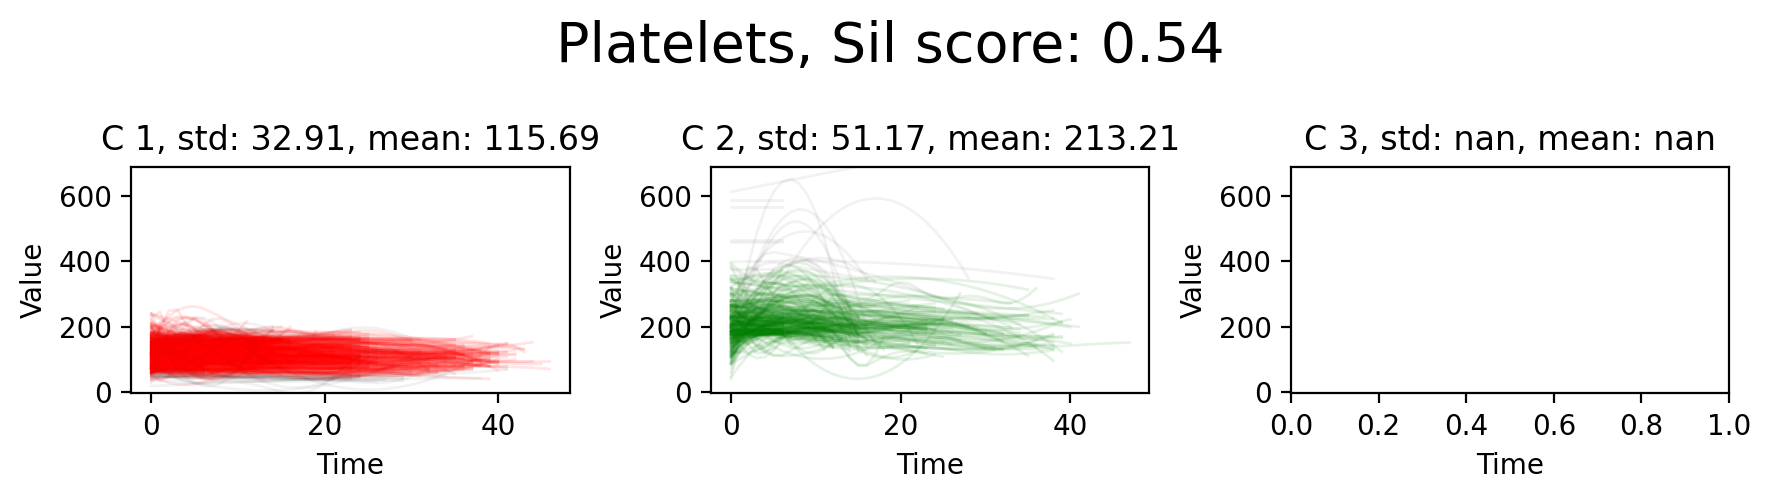

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


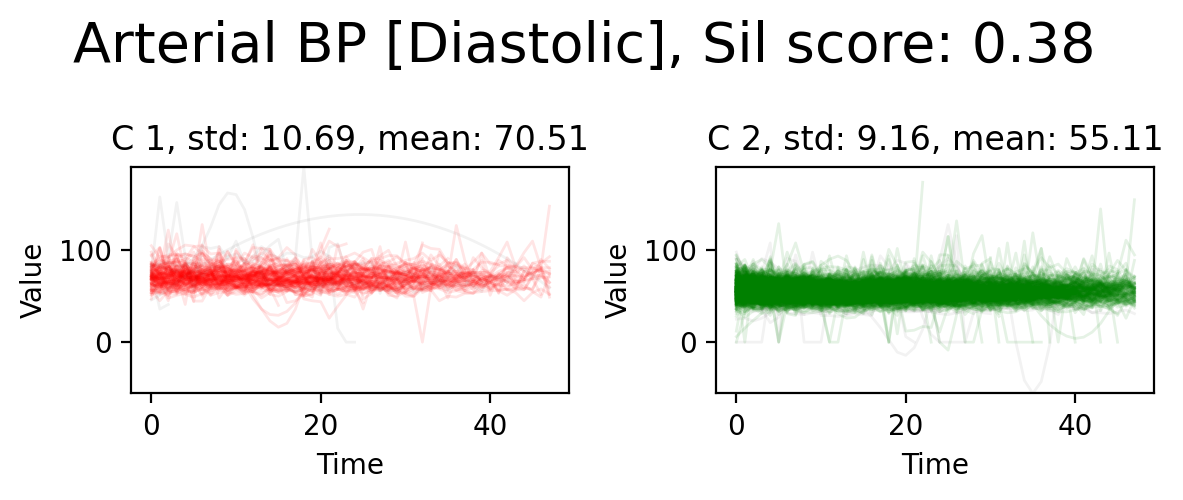

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


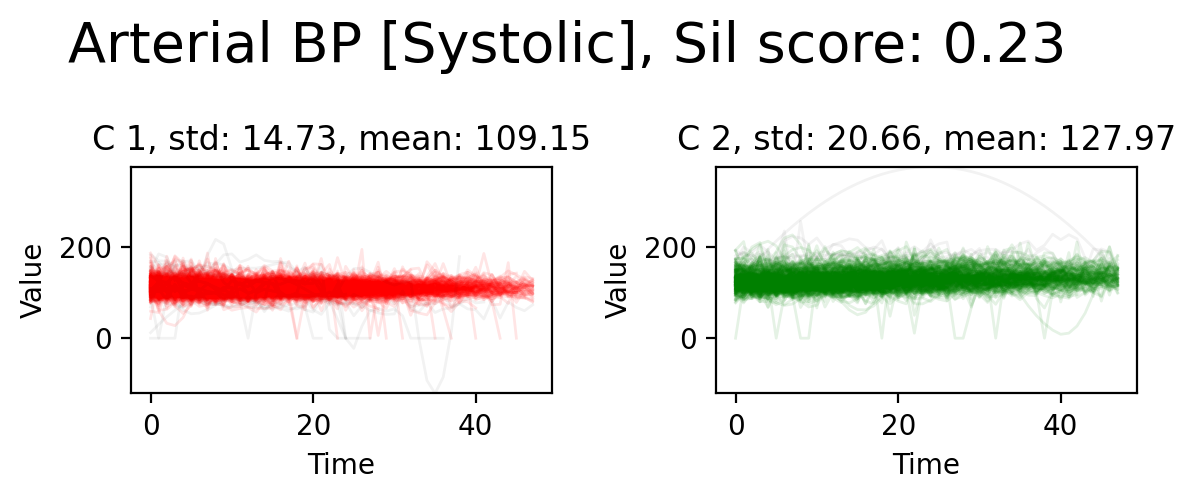

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


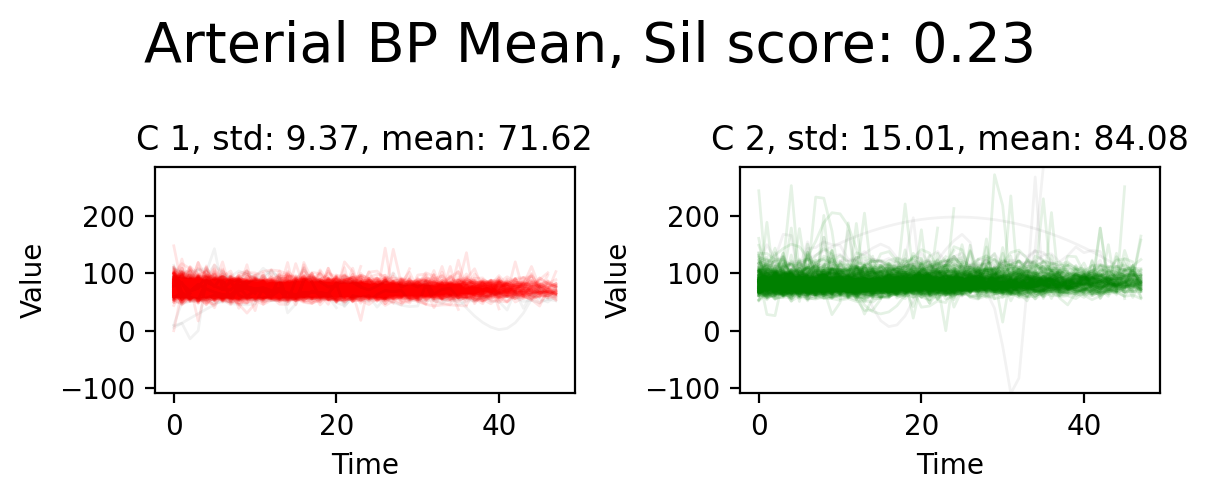

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


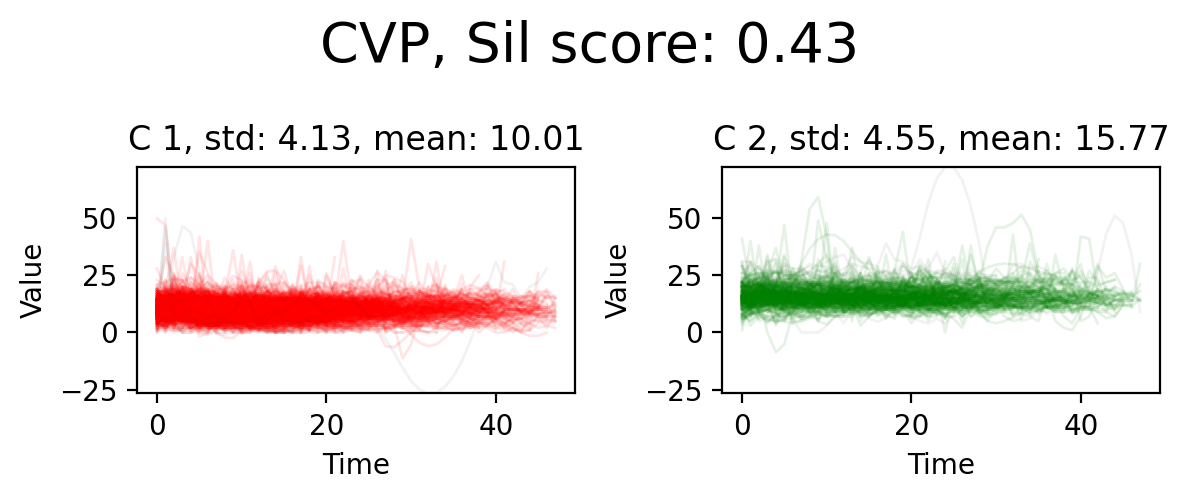

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


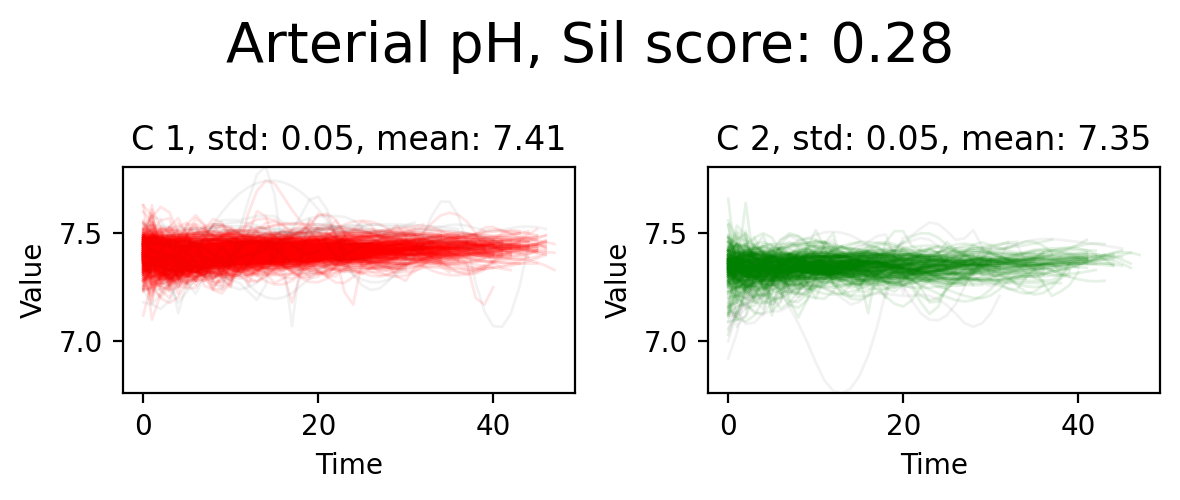

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


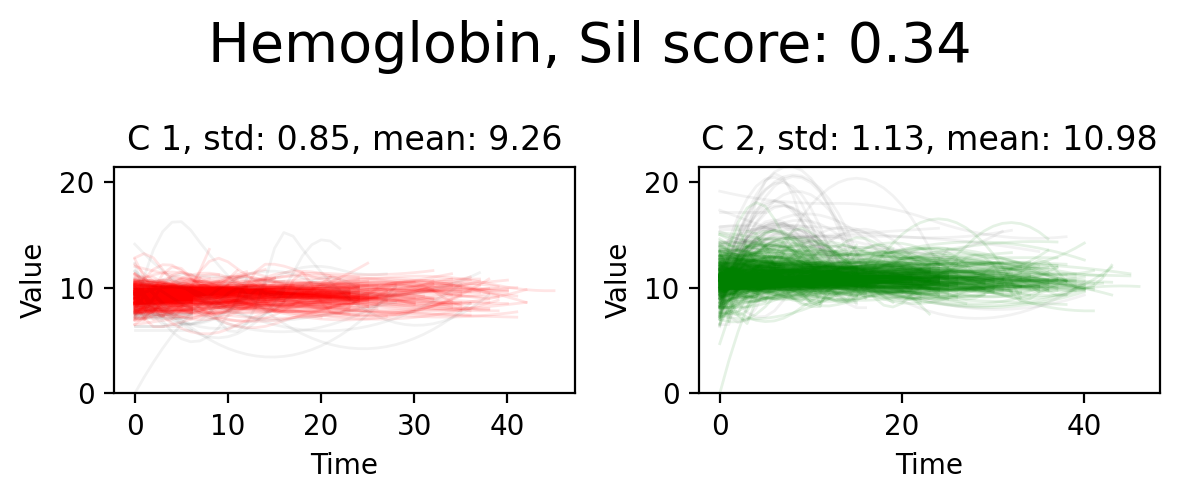

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


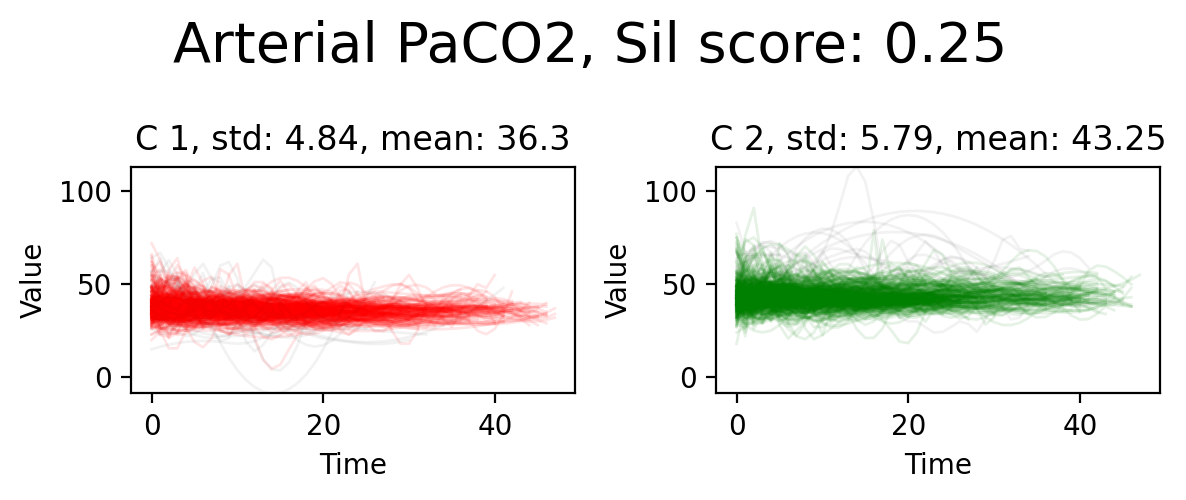

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


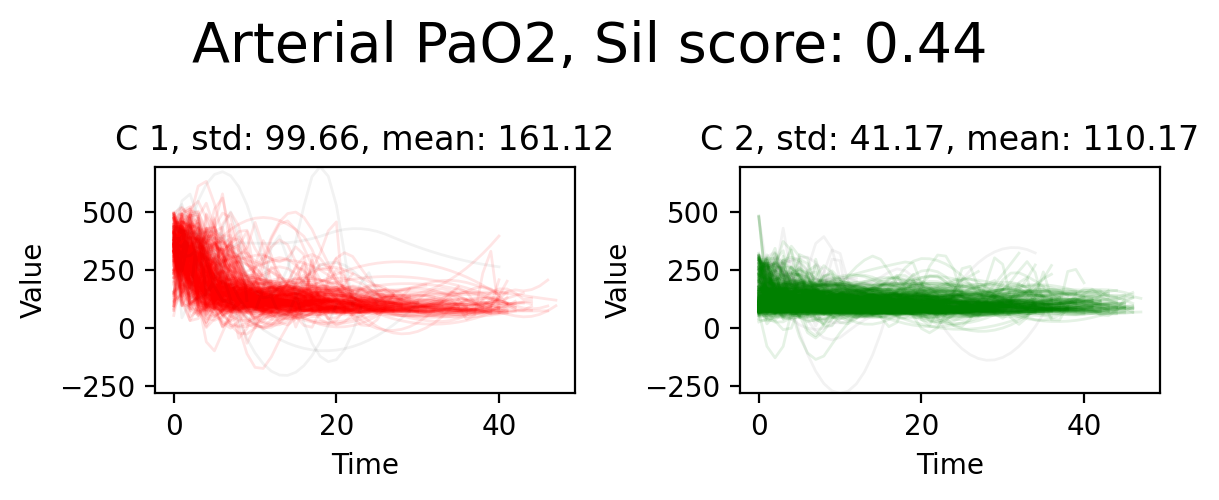

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


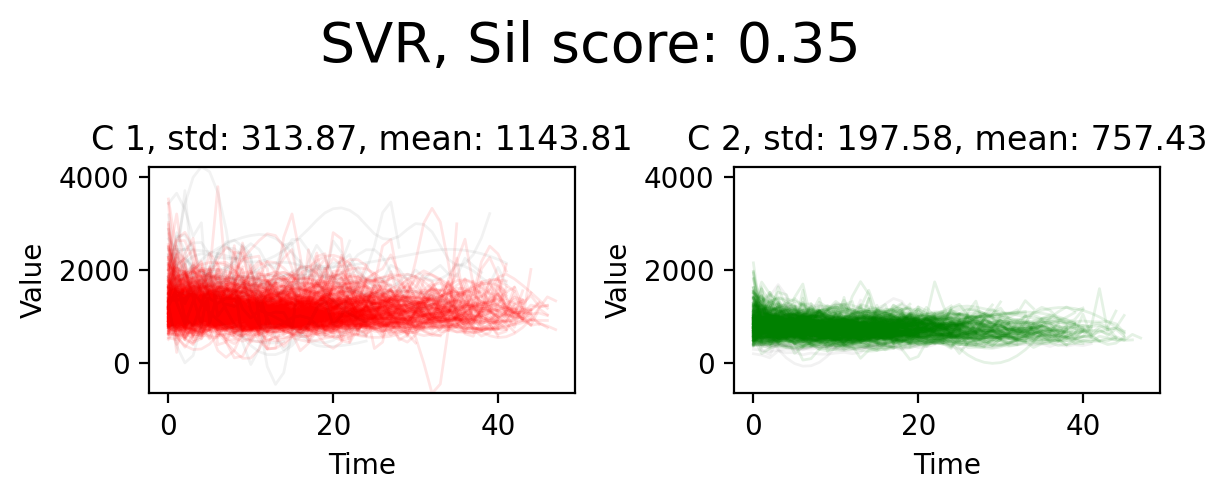

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


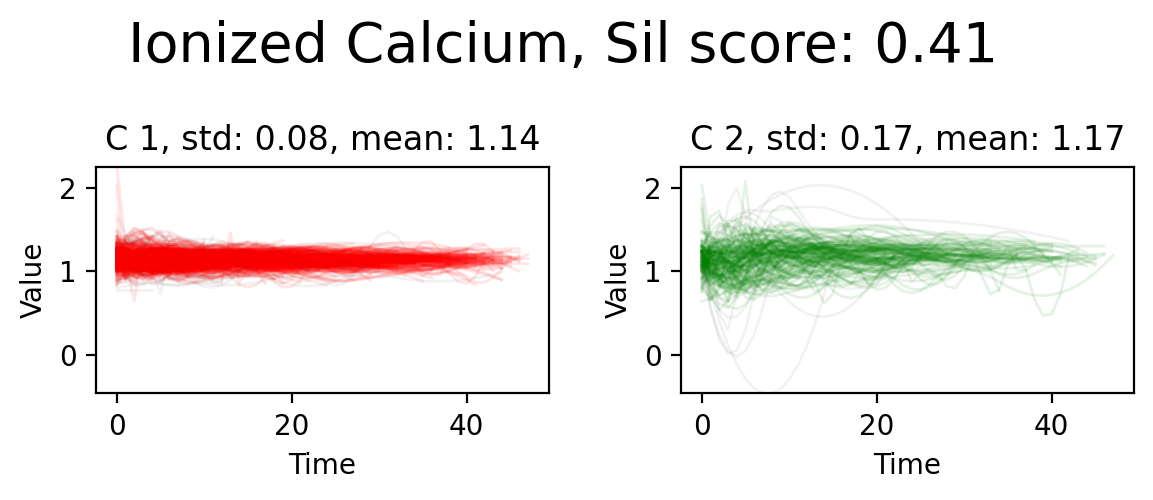

Creating stacked DF...
Cleaning
Creating stacked DF...
Cleaning


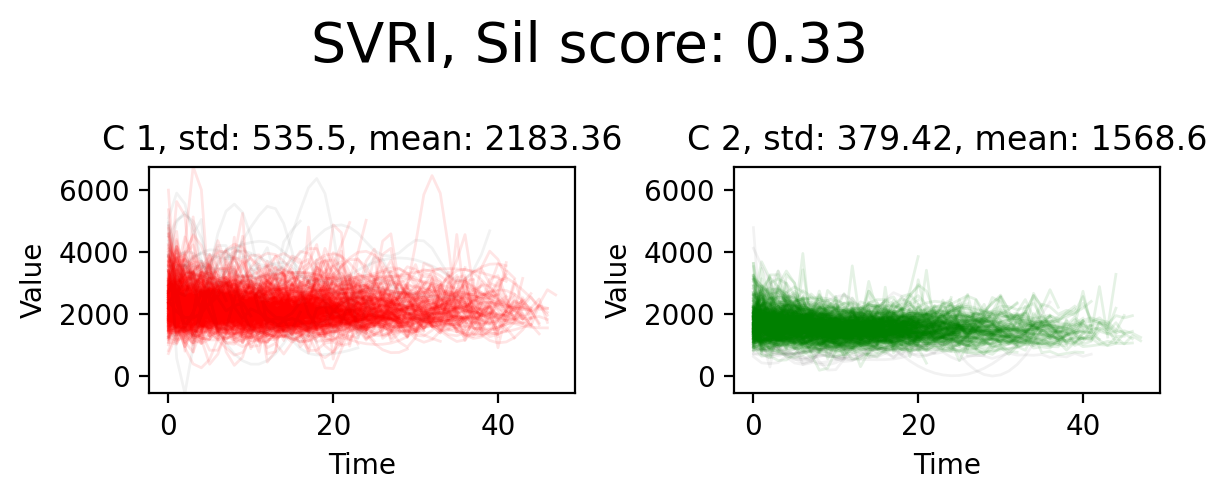

Feature      StdDev         Mean
0                 Platelets   32.911185   115.688955
1                 Platelets   51.173290   213.205917
2                 Platelets         NaN          NaN
3   Arterial BP [Diastolic]   10.687998    70.507422
4   Arterial BP [Diastolic]    9.160861    55.108864
5    Arterial BP [Systolic]   14.730699   109.146938
6    Arterial BP [Systolic]   20.660571   127.970590
7          Arterial BP Mean    9.367252    71.622392
8          Arterial BP Mean   15.009026    84.075615
9                       CVP    4.128313    10.011611
10                      CVP    4.554739    15.773143
11              Arterial pH    0.047647     7.411806
12              Arterial pH    0.049982     7.345670
13               Hemoglobin    0.845256     9.256344
14               Hemoglobin    1.129720    10.979583
15           Arterial PaCO2    4.844450    36.297893
16           Arterial PaCO2    5.786573    43.248340
17            Arterial PaO2   99.656593   161.117810
18            Arterial PaO2   41.174446   110.165718
19                      SVR  313.874040  1143.811272
20                      SVR  197.583081   757.429489
21          Ionized Calcium    0.075625     1.137670
22          Ionized Calcium    0.166247     1.170507
23                     SVRI  535.504012  2183.356707
24                     SVRI  379.416213  1568.601757

In [ ]:
colours = {0:'r', 1:'g', 2:'b', 3:'c', 4:'m', 5:'y', 6:'k', 7:'w', 8:'orange', 9:'purple', 10:'pink'}

clusterMetricsList = []

for col in clusterNums:

    clusters = clusterNums[col]

    fig = plt.figure(figsize=(clusters*3,2.5), dpi=200)

    fig.suptitle(f"{col}, Sil score: {np.round(scores[col], 2)}", fontsize=20)
    

    colData = [np.pad(j.interpolatedData[col].values, (0, 48 - len(j.interpolatedData[col].values)), 'constant', constant_values = (np.NaN, np.NaN)) for j in clusteringPatients]
    # print(colData)

    minVal, maxVal = np.nanmin([np.nanmin(j) for j in colData]), np.nanmax([np.nanmax(j) for j in colData])

    for i in range(clusters):
        plt.subplot(1, clusters, i+1)

        y_pred = clusteredDF[col]

        # dataCluster = np.array(colData)[y_pred == i]

        dataCluster = formatForTimeSeries(col)[y_pred == i]

        withoutOutliers, outliers = removeOutliers(dataCluster, 1.5)
        
        # print(f"Num removed: {len(dataCluster) - len(withoutOutliers)}")

        # print(len(dataCluster))
        # print(len(withoutOutliers))
        
        for sample in outliers:
            plt.plot(sample, c='black', alpha=0.05, linewidth=1)
        
        for sample in withoutOutliers:
            plt.plot(sample, c=colours[i], alpha=0.1, linewidth=1)

        stdDev = np.nanstd(withoutOutliers)
        mean = np.nanmean(withoutOutliers)

        clusterMetricsList.append([col, stdDev, mean])

        plt.title(f"C {i+1}, std: {np.round(stdDev, 2)}, mean: {np.round(mean, 2)}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        # print(dataCluster)
        # print(np.nanstd(dataCluster))
        plt.ylim(minVal, maxVal)

        
    plt.tight_layout()
    plt.savefig(f"./figures/{col}.png")
    plt.show()
    


clusterMetricsDF = pd.DataFrame(data = clusterMetricsList, columns=['Feature', 'StdDev', 'Mean'])
display(clusterMetricsDF)


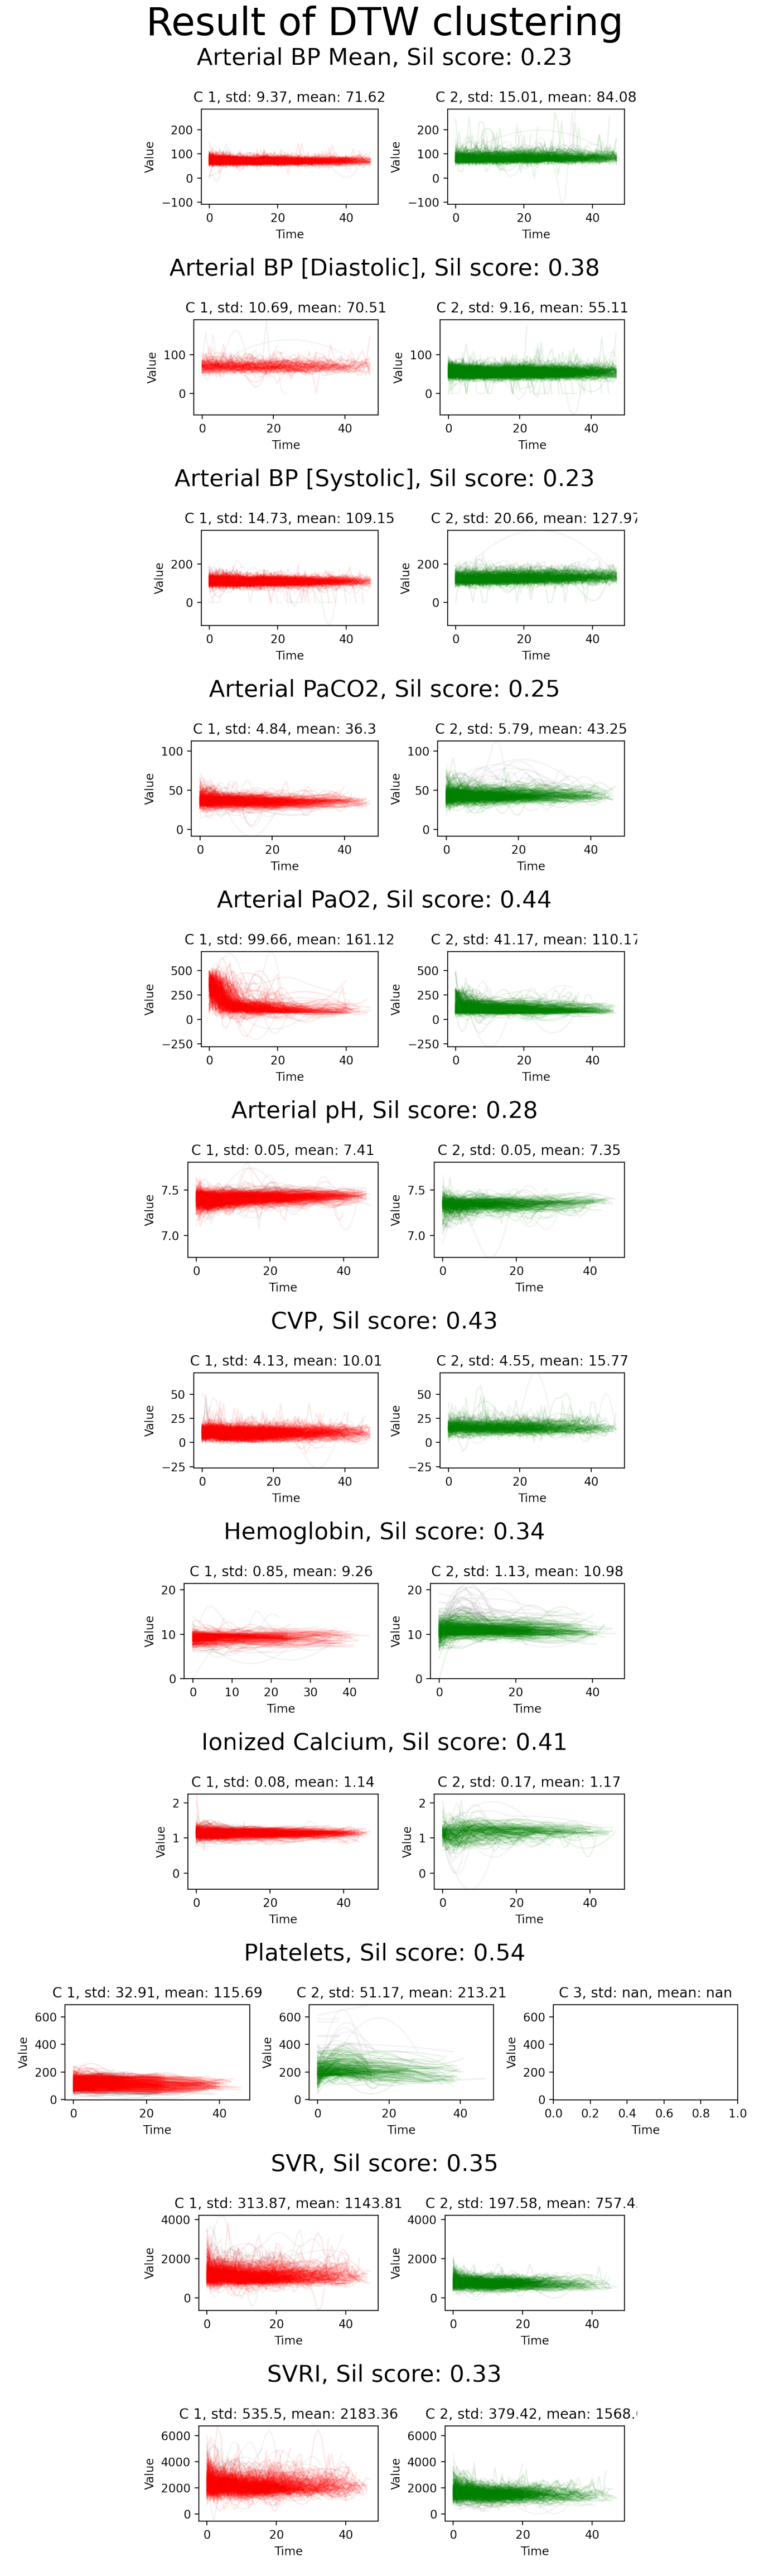

In [ ]:
# figdir = "./figures/"

# images = [Image.open(figdir + x) for x in list(next(os.walk(figdir))[2:])[0]]

# widths, heights = zip(*(i.size for i in images))

# widthMax = max(widths)
# widthMin = min(widths)
# heightTotal = sum(heights)

# combined = Image.new('RGBA', (widthMax, heightTotal))

# offset = 0
# for im in images:
#   xOffset = 0
#   if im.size[0] != widthMax:
#     xOffset = (widthMax - im.size[0]) // 2
#   combined.paste(im, (xOffset, offset))
#   offset += im.size[1]


# fig = plt.figure(figsize=(widthMax/100, heightTotal/100), dpi=100)
# plt.title("Result of DTW clustering", fontsize=50)
# plt.axis('off')
# # plt.tight_layout()
# plt.imshow(combined)
# plt.show()


# new_im.save('test.jpg')

### Order by std dev to find the clusters that vary the most, order by mean to find the highest/lowest values.

In [ ]:
# from sklearn.preprocessing import KBinsDiscretizer  
# est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

display(clusteredDF.head())

# orderedDF = copy.copy(clusteredDF)

def getMapping(metric, subset):
    
    ordered = subset.reset_index().sort_values(by=metric, ascending=True)

    before = ordered.index
    after = ordered.reset_index().index

    mapping = {before[i]: after[i] for i in range(len(before))}

    return mapping



orderedDF = pd.DataFrame()

for name, subset in clusterMetricsDF.groupby('Feature'):

    # clusterData = [np.pad(j.interpolatedData[col].values, (0, 48 - len(j.interpolatedData[col].values)), 'constant', constant_values = (np.NaN, np.NaN)) for j in clusteringPatients]

    for metric in list(clusterMetricsDF.columns)[1:]:

        mapping = getMapping(metric, subset)

        newCol = str(name + "_" + metric)

        orderedDF[newCol] = clusteredDF[name].map(mapping)


# orderedDF = orderedDF.set_index(clusteredDF.index)


display(orderedDF.head())


Platelets  Arterial BP [Diastolic]  Arterial BP [Systolic]  \
PatientID                                                               
0                  0                        1                       1   
0                  1                        1                       0   
0                  0                        1                       1   
0                  0                        1                       0   
0                  0                        1                       0   

           Arterial BP Mean  CVP  Arterial pH  Hemoglobin  Arterial PaCO2  \
PatientID                                                                   
0                         0    0            1           1               1   
0                         0    0            0           1               1   
0                         0    0            0           0               0   
0                         0    1            1           1               0   
0                         0    0            1           1               1   

           Arterial PaO2  SVR  Ionized Calcium  SVRI  
PatientID                                             
0                      0    0                0     0  
0                      0    0                1     0  
0                      0    0                0     0  
0                      1    0                0     0  
0                      0    1                0     0

Arterial BP Mean_StdDev  Arterial BP Mean_Mean  \
PatientID                                                   
0                                0                      0   
0                                0                      0   
0                                0                      0   
0                                0                      0   
0                                0                      0   

           Arterial BP [Diastolic]_StdDev  Arterial BP [Diastolic]_Mean  \
PatientID                                                                 
0                                       0                             0   
0                                       0                             0   
0                                       0                             0   
0                                       0                             0   
0                                       0                             0   

           Arterial BP [Systolic]_StdDev  Arterial BP [Systolic]_Mean  \
PatientID                                                               
0                                      1                            1   
0                                      0                            0   
0                                      1                            1   
0                                      0                            0   
0                                      0                            0   

           Arterial PaCO2_StdDev  Arterial PaCO2_Mean  Arterial PaO2_StdDev  \
PatientID                                                                     
0                              1                    1                     1   
0                              1                    1                     1   
0                              0                    0                     1   
0                              0                    0                     0   
0                              1                    1                     1   

           Arterial PaO2_Mean  ...  Hemoglobin_StdDev  Hemoglobin_Mean  \
PatientID                      ...                                       
0                           1  ...                  1                1   
0                           1  ...                  1                1   
0                           1  ...                  0                0   
0                           0  ...                  1                1   
0                           1  ...                  1                1   

           Ionized Calcium_StdDev  Ionized Calcium_Mean  Platelets_StdDev  \
PatientID                                                                   
0                               0                     0                 0   
0                               1                     1                 1   
0                               0                     0                 0   
0                               0                     0                 0   
0                               0                     0                 0   

           Platelets_Mean  SVR_StdDev  SVR_Mean  SVRI_StdDev  SVRI_Mean  
PatientID                                                                
0                       0           1         1            1          1  
0                       1           1         1            1          1  
0                       0           1         1            1          1  
0                       0           1         1            1          1  
0                       0           0         0            1          1  

[5 rows x 24 columns]

In [ ]:
# reload(Categorization)

cat = Categorization.Categorizer()

mapping = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}

mapped = cat.map_types(data = {"ordered":orderedDF}, mapping={0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'})['ordered']

display(mapped)

Arterial BP Mean_StdDev_high  Arterial BP Mean_StdDev_low  \
PatientID                                                              
0                                     0                            1   
0                                     0                            1   
0                                     0                            1   
0                                     0                            1   
0                                     0                            1   
...                                 ...                          ...   
0                                     1                            0   
0                                     1                            0   
0                                     0                            1   
0                                     0                            1   
0                                     0                            1   

           Arterial BP Mean_Mean_high  Arterial BP Mean_Mean_low  \
PatientID                                                          
0                                   0                          1   
0                                   0                          1   
0                                   0                          1   
0                                   0                          1   
0                                   0                          1   
...                               ...                        ...   
0                                   1                          0   
0                                   1                          0   
0                                   0                          1   
0                                   0                          1   
0                                   0                          1   

           Arterial BP [Diastolic]_StdDev_high  \
PatientID                                        
0                                            0   
0                                            0   
0                                            0   
0                                            0   
0                                            0   
...                                        ...   
0                                            0   
0                                            1   
0                                            0   
0                                            0   
0                                            0   

           Arterial BP [Diastolic]_StdDev_low  \
PatientID                                       
0                                           1   
0                                           1   
0                                           1   
0                                           1   
0                                           1   
...                                       ...   
0                                           1   
0                                           0   
0                                           1   
0                                           1   
0                                           1   

           Arterial BP [Diastolic]_Mean_high  \
PatientID                                      
0                                          0   
0                                          0   
0                                          0   
0                                          0   
0                                          0   
...                                      ...   
0                                          0   
0                                          1   
0                                          0   
0                                          0   
0                                          0   

           Arterial BP [Diastolic]_Mean_low  \
PatientID                                     
0                                         1   
0                                         1   
0                                         1   
0                                       

In [ ]:
targetSeries = [patient.label for patient in clusteringPatients]

# targetSeries

In [ ]:
pd.Series(targetSeries).value_counts()

0    924
1     35
dtype: int64

In [ ]:
mapped['Mortality14Days'] = targetSeries

display(mapped)

mapped.to_csv("./categorisedData/clusteredDataAllCols.csv")

Arterial BP Mean_StdDev_high  Arterial BP Mean_StdDev_low  \
PatientID                                                              
0                                     0                            1   
0                                     0                            1   
0                                     0                            1   
0                                     0                            1   
0                                     0                            1   
...                                 ...                          ...   
0                                     1                            0   
0                                     1                            0   
0                                     0                            1   
0                                     0                            1   
0                                     0                            1   

           Arterial BP Mean_Mean_high  Arterial BP Mean_Mean_low  \
PatientID                                                          
0                                   0                          1   
0                                   0                          1   
0                                   0                          1   
0                                   0                          1   
0                                   0                          1   
...                               ...                        ...   
0                                   1                          0   
0                                   1                          0   
0                                   0                          1   
0                                   0                          1   
0                                   0                          1   

           Arterial BP [Diastolic]_StdDev_high  \
PatientID                                        
0                                            0   
0                                            0   
0                                            0   
0                                            0   
0                                            0   
...                                        ...   
0                                            0   
0                                            1   
0                                            0   
0                                            0   
0                                            0   

           Arterial BP [Diastolic]_StdDev_low  \
PatientID                                       
0                                           1   
0                                           1   
0                                           1   
0                                           1   
0                                           1   
...                                       ...   
0                                           1   
0                                           0   
0                                           1   
0                                           1   
0                                           1   

           Arterial BP [Diastolic]_Mean_high  \
PatientID                                      
0                                          0   
0                                          0   
0                                          0   
0                                          0   
0                                          0   
...                                      ...   
0                                          0   
0                                          1   
0                                          0   
0                                          0   
0                                          0   

           Arterial BP [Diastolic]_Mean_low  \
PatientID                                     
0                                         1   
0                                         1   
0                                         1   
0                                       

In [ ]:
minority = mapped[mapped['Mortality14Days'] == 1]

majority = mapped[mapped['Mortality14Days'] == 0]

display(mapped.describe())
display(minority.describe())
display(majority.describe())

Arterial BP Mean_StdDev_high  Arterial BP Mean_StdDev_low  \
count                    959.000000                   959.000000   
mean                       0.345151                     0.654849   
std                        0.475666                     0.475666   
min                        0.000000                     0.000000   
25%                        0.000000                     0.000000   
50%                        0.000000                     1.000000   
75%                        1.000000                     1.000000   
max                        1.000000                     1.000000   

       Arterial BP Mean_Mean_high  Arterial BP Mean_Mean_low  \
count                  959.000000                 959.000000   
mean                     0.345151                   0.654849   
std                      0.475666                   0.475666   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   1.000000   
75%                      1.000000                   1.000000   
max                      1.000000                   1.000000   

       Arterial BP [Diastolic]_StdDev_high  \
count                           959.000000   
mean                              0.122002   
std                               0.327459   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       Arterial BP [Diastolic]_StdDev_low  Arterial BP [Diastolic]_Mean_high  \
count                          959.000000                         959.000000   
mean                             0.877998                           0.122002   
std                              0.327459                           0.327459   
min                              0.000000                           0.000000   
25%                              1.000000                           0.000000   
50%                              1.000000                           0.000000   
75%                              1.000000                           0.000000   
max                              1.000000                           1.000000   

       Arterial BP [Diastolic]_Mean_low  Arterial BP [Systolic]_StdDev_high  \
count                        959.000000                          959.000000   
mean                           0.877998                            0.353493   
std                            0.327459                            0.478304   
min                            0.000000                            0.000000   
25%                            1.000000                            0.000000   
50%                            1.000000                            0.000000   
75%                            1.000000                            1.000000   
max                            1.000000                            1.000000   

       Arterial BP [Systolic]_StdDev_low  ...  Platelets_Mean_low  \
count                         959.000000  ...          959.000000   
mean                            0.646507  ...            0.685089   
std                             0.478304  ...            0.464723   
min                             0.000000  ...            0.000000   
25%                             0.000000  ...            0.000000   
50%                             1.000000  ...            1.000000   
75%                             1.000000  ...            1.000000   
max                             1.000000  ...            1.000000   

       SVR_StdDev_high  SVR_StdDev_low  SVR_Mean_high  SVR_Mean_low  \
count       959.000000      959.000000     959.000000    959.000000   
mean          0.533889        0.466111       0.533889      0.466111   
std           0.499110        0.499110       0.499110      0.499110   
min           0.000000        0.000000       0.000000      0.00

Arterial BP Mean_StdDev_high  Arterial BP Mean_StdDev_low  \
count                     35.000000                    35.000000   
mean                       0.428571                     0.571429   
std                        0.502096                     0.502096   
min                        0.000000                     0.000000   
25%                        0.000000                     0.000000   
50%                        0.000000                     1.000000   
75%                        1.000000                     1.000000   
max                        1.000000                     1.000000   

       Arterial BP Mean_Mean_high  Arterial BP Mean_Mean_low  \
count                   35.000000                  35.000000   
mean                     0.428571                   0.571429   
std                      0.502096                   0.502096   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   1.000000   
75%                      1.000000                   1.000000   
max                      1.000000                   1.000000   

       Arterial BP [Diastolic]_StdDev_high  \
count                             35.00000   
mean                               0.20000   
std                                0.40584   
min                                0.00000   
25%                                0.00000   
50%                                0.00000   
75%                                0.00000   
max                                1.00000   

       Arterial BP [Diastolic]_StdDev_low  Arterial BP [Diastolic]_Mean_high  \
count                            35.00000                           35.00000   
mean                              0.80000                            0.20000   
std                               0.40584                            0.40584   
min                               0.00000                            0.00000   
25%                               1.00000                            0.00000   
50%                               1.00000                            0.00000   
75%                               1.00000                            0.00000   
max                               1.00000                            1.00000   

       Arterial BP [Diastolic]_Mean_low  Arterial BP [Systolic]_StdDev_high  \
count                          35.00000                           35.000000   
mean                            0.80000                            0.428571   
std                             0.40584                            0.502096   
min                             0.00000                            0.000000   
25%                             1.00000                            0.000000   
50%                             1.00000                            0.000000   
75%                             1.00000                            1.000000   
max                             1.00000                            1.000000   

       Arterial BP [Systolic]_StdDev_low  ...  Platelets_Mean_low  \
count                          35.000000  ...           35.000000   
mean                            0.571429  ...            0.742857   
std                             0.502096  ...            0.443440   
min                             0.000000  ...            0.000000   
25%                             0.000000  ...            0.500000   
50%                             1.000000  ...            1.000000   
75%                             1.000000  ...            1.000000   
max                             1.000000  ...            1.000000   

       SVR_StdDev_high  SVR_StdDev_low  SVR_Mean_high  SVR_Mean_low  \
count        35.000000       35.000000      35.000000     35.000000   
mean          0.514286        0.485714       0.514286      0.485714   
std           0.507093        0.507093       0.507093      0.507093   
min           0.000000        0.000000       0.000000      0.00

Arterial BP Mean_StdDev_high  Arterial BP Mean_StdDev_low  \
count                    924.000000                   924.000000   
mean                       0.341991                     0.658009   
std                        0.474634                     0.474634   
min                        0.000000                     0.000000   
25%                        0.000000                     0.000000   
50%                        0.000000                     1.000000   
75%                        1.000000                     1.000000   
max                        1.000000                     1.000000   

       Arterial BP Mean_Mean_high  Arterial BP Mean_Mean_low  \
count                  924.000000                 924.000000   
mean                     0.341991                   0.658009   
std                      0.474634                   0.474634   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   1.000000   
75%                      1.000000                   1.000000   
max                      1.000000                   1.000000   

       Arterial BP [Diastolic]_StdDev_high  \
count                           924.000000   
mean                              0.119048   
std                               0.324020   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       Arterial BP [Diastolic]_StdDev_low  Arterial BP [Diastolic]_Mean_high  \
count                          924.000000                         924.000000   
mean                             0.880952                           0.119048   
std                              0.324020                           0.324020   
min                              0.000000                           0.000000   
25%                              1.000000                           0.000000   
50%                              1.000000                           0.000000   
75%                              1.000000                           0.000000   
max                              1.000000                           1.000000   

       Arterial BP [Diastolic]_Mean_low  Arterial BP [Systolic]_StdDev_high  \
count                        924.000000                          924.000000   
mean                           0.880952                            0.350649   
std                            0.324020                            0.477432   
min                            0.000000                            0.000000   
25%                            1.000000                            0.000000   
50%                            1.000000                            0.000000   
75%                            1.000000                            1.000000   
max                            1.000000                            1.000000   

       Arterial BP [Systolic]_StdDev_low  ...  Platelets_Mean_low  \
count                         924.000000  ...          924.000000   
mean                            0.649351  ...            0.682900   
std                             0.477432  ...            0.465599   
min                             0.000000  ...            0.000000   
25%                             0.000000  ...            0.000000   
50%                             1.000000  ...            1.000000   
75%                             1.000000  ...            1.000000   
max                             1.000000  ...            1.000000   

       SVR_StdDev_high  SVR_StdDev_low  SVR_Mean_high  SVR_Mean_low  \
count       924.000000      924.000000     924.000000    924.000000   
mean          0.534632        0.465368       0.534632      0.465368   
std           0.499069        0.499069       0.499069      0.499069   
min           0.000000        0.000000       0.000000      0.00